# Tutorial 4: Computing $B_\ell(k_1,k_2,k_3)$ from Simulations

In this tutorial we will demonstrate how to use PolyBin3D to efficiently compute the bispectrum multipoles from simulations using the ``Bk_ideal`` and ``Bk_unwindowed`` functions. For testing, we'll mostly use idealized geometries with a constant mask, though non-trivial geometries can be added as shown in the power spectrum tutorials.

### Preliminaries

We start by importing the packages we'll need, as well as defining some useful plotting functions.

In [1]:
%pylab inline
from nbodykit.lab import * # for creating testing data
from scipy.special import legendre
from scipy.interpolate import interp1d
import PolyBin3D as pb # the main code

def plotter(mat,axis=2,shift=True,vmax=None,title=''):
    """General purpose function for plotting a 3D density field, averaging over a specified axis. 
    
    We optionally apply an FFTshift operation, and truncate the plot to some symmetric range of values: [-vmax, vmax].
    """
    plt.figure()
    if shift:
        plot_mat = np.fft.fftshift(mat)
    else:
        plot_mat = mat
    to_plot = plot_mat.real.mean(axis=axis)
    if vmax is None:
        vmax = np.max(np.abs(to_plot))
    if len(title)>0:
        plt.title(title)
    plt.imshow(to_plot,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.show();
    
def plot_corr(f, v=1, subtract_identity=True, title=''):
    """Plot a correlation matrix, optionally subtracting the identity."""
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    if len(title)>0:
        plt.title(title)
    plt.imshow(cfish-subtract_identity*np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();
    
    for i in range(bspec.Nl-1):
        plt.hlines((i+1)*bspec.N3-0.5, 0, 2*bspec.N_bins, linestyles='--',alpha=0.5)
        plt.vlines((i+1)*bspec.N3-0.5, 0, 2*bspec.N_bins, linestyles='--',alpha=0.5)
    plt.xlim(-0.5,bspec.N_bins-0.5)
    plt.ylim(bspec.N_bins-0.5,-0.5)
    plt.xlabel('Bin Index 1',fontsize=12)
    plt.ylabel('Bin Index 2',fontsize=12)

Populating the interactive namespace from numpy and matplotlib


### 1. Bispectra from Periodic Boxes

To demonstrate PolyBin3D's bispectrum implementation, we'll compute the bispectrum multipoles of a lognormal galaxy simulation. This has an ideal periodic geometry, so its bispectrum can be (relatively) easily computed.  

As in Tutorial 1, we'll some fake simulation data using Nbodykit, drawing a lognormal sample and computing the fractional overdensity field, $\delta$. We could also feed in a continuous density field instead of the interpolated galaxy field (e.g. the matter density from a simulation, or a Gaussian random field).

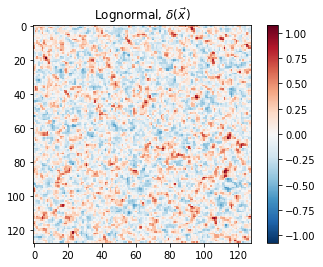

In [2]:
# Create a simple galaxy power spectrum
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0
fz = cosmo.scale_independent_growth_rate(redshift)
nbar = 3e-4

# Sample parameters
boxsize = 1000.
gridsize = 128

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)

# Add some redshift-space distortions along the z-axis
cat['Position'] += cat['VelocityOffset'] * [0,0,1]
cat['Position'] %= boxsize
cat['Position'] -= boxsize/2. # center on zero

# Convert the catalog to a grid, with TSC interpolation and interlacing
density_grid = cat.to_mesh(compensated=False, resampler='tsc', interlaced=True, position='Position').compute()
density_grid -= 1.

# Let's plot the field
plotter(density_grid, title=r'Lognormal, $\delta(\vec x)$')

Next, we load PolyBin3D, optionally specifying a fiducial power spectrum monopole, which will be used as a weighting within each bin of the power spectrum estimator.

As before, we also need to decide the pixel window function, which accounts for the interpolation of discrete data onto the grid. The options are ``{'none','cic','tsc','pcs','interlaced-cic','interlaced-tsc','interlaced-pcs'}``. If no interpolation is used (e.g. for continuous simulation outputs), or if the density field is already pixel-window-corrected (e.g., using ``compensated=True`` above), then the pixel window should be set to ``'none'``.

In [3]:
# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Load the PolyBin3D class using the fiducial power spectrum
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=[0,0,0], # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs ('fftw' for cpu, 'jax' for gpu)
                 nthreads=4, # number of CPUs for performing FFTs (only applies to 'fftw' backend)
                 sightline='global', # line-of-sight [global = z-axis, local = relative to pair]
                )

### An aside: we can use PolyBin3D to create Gaussian random fields with the fiducial redshift-space power spectrum:
# density_grid = base.generate_data(seed=42, Pk_input = Pk_theory, output_type='real')


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc


To compute bispectra, we need to specify a desired $k$-binning strategy and a maximum Legendre multipole, $\ell$. The code will then compute all bispectra of the form $B_\ell(k_1,k_2,k_3)$ with even $\ell$ and $k_1\leq k_2\leq k_3$ satisfying triangle conditions. We can optionally tell PolyBin3D to use different binning for squeezed and unsqueezed triangles, ensuring that we don't waste computation time.

As for the power spectrum, we can optionally weight the bispectra by a $1/P_{\rm fiducial}(k)$ to maximize signal-to-noise in each bin. We can additionally include or exclude configurations where the center of the bin-triplet does not satisfy the triangle conditions but other modes in the bin do. Including them would slightly increase the signal-to-noise and may be important for mask effects.


Binning: 4 bins in [0.010, 0.090] h/Mpc
Squezed binning: 6 bins in [0.010, 0.130] h/Mpc
l-max: 2
N_bins: 78
Mask: constant


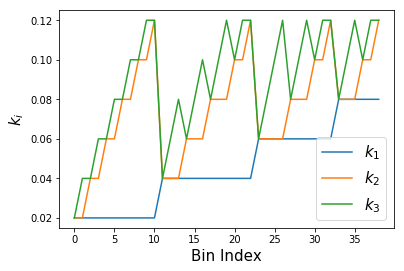

In [4]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.10,0.02)
k_edges_squeeze = np.arange(0.01,0.15,0.02) # add extra high-k bins for squeezed triangles
lmax = 2

# Load the bispectrum class
bspec = pb.BSpec(base, 
                 k_edges, # one-dimensional bin edges
                 applySinv = None, # weighting function [only needed for unwindowed estimators]
                 mask = None, # real-space mask
                 lmax = lmax, # maximum Legendre multipole
                 k_bins_squeeze = k_edges_squeeze, # squeezed bins
                 include_partial_triangles = False, # whether to include bins whose centers do not satisfy triangle conditions
                )

# Plot k-bins
k123 = bspec.get_ks()
for i in range(3):
    plt.plot(k123[i],label=r'$k_%d$'%(i+1))
plt.legend(fontsize=15);
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_i$',fontsize=15);

Now we'll proceed to compute bispectra with the ``Bk_ideal`` routine. This is appropriate here since we're working with unmasked periodic data. 

For the ideal estimators we can optionally include discreteness effects in the normalization of the higher-order Legendre multipoles. These essentially correct for the fact that $\int d\hat{k}\,L_\ell(\hat{k}\cdot\hat{z})L_{\ell'}(\hat{k}\cdot\hat{z})\not\propto \frac{\delta_{\ell\ell'}^{\rm K}}{2\ell+1}$ on a finite grid, and are typically very small.

In [5]:
# Compute the ideal bispectrum with and without the discretess correction
bk_corr = bspec.Bk_ideal(density_grid, discreteness_correction=True)
bk_uncorr = bspec.Bk_ideal(density_grid, discreteness_correction=False)

## Print number of FFTs used for diagnostics
print("\nComputations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

Computing degeneracy factor
Computing ideal Fisher matrix
Computing ideal Fisher matrix

Computations complete using 2 forward and 96 reverse FFTs


Let's plot the results. As expected, the discreteness corrections are *very* small and can usually be dropped in practice for a faster estimator. As expected, the quadrupole is consistent with zero though we find a slight monopole, likely dominated by shot-noise effects (which we do not subtract off).

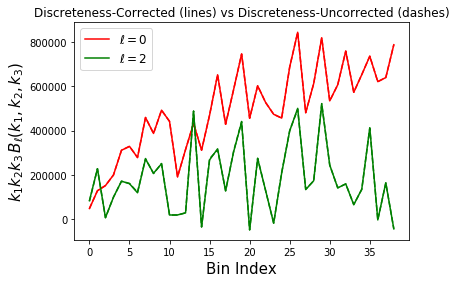

In [6]:
cs = ['r','g']
weight = k123.prod(axis=0)
for l in range(0,lmax+1,2):
    plt.plot(weight*bk_corr['b%d'%l],c=cs[l//2],label=r'$\ell=%d$'%l)
    plt.plot(weight*bk_uncorr['b%d'%l],c=cs[l//2],ls='--')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12);
plt.title('Discreteness-Corrected (lines) vs Discreteness-Uncorrected (dashes)',fontsize=12);

We can also plot the ideal Fisher (= normalization) matrices. In the limit of a Gaussian density field and the fiducial power spectrum equalling the truth, this is equal to the inverse covariance of the estimator.

Here we observe that the idealized Fisher matrix is highly diagonal (noting that we assume a *monopole* theory spectrum), with small corrections induced by the discreteness correction.

Computing ideal Fisher matrix
Computing ideal Fisher matrix


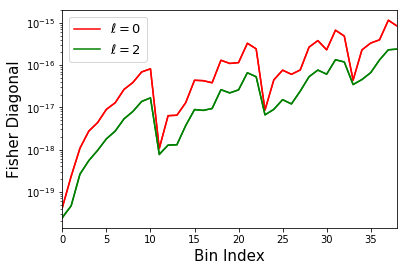

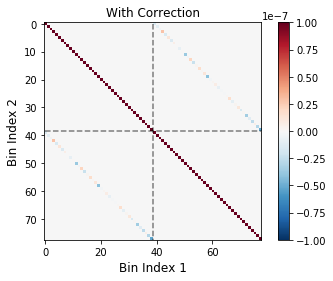

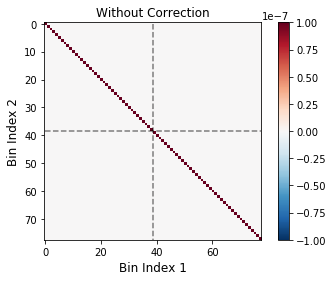

In [7]:
# (Re)compute the ideal Fisher matrix with and without the discretess correction
fish_ideal_corr = bspec.compute_fisher_ideal(discreteness_correction=True)
fish_ideal_uncorr = bspec.compute_fisher_ideal(discreteness_correction=False)

for l in range(0, lmax+1, 2):
    plt.plot(np.diag(fish_ideal_corr)[l//2*bspec.N3:(l//2+1)*bspec.N3], c=cs[l//2], label=r'$\ell=%d$'%l)
    plt.plot(np.diag(fish_ideal_uncorr)[l//2*bspec.N3:(l//2+1)*bspec.N3], c=cs[l//2])
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'Fisher Diagonal',fontsize=15)
plt.legend(fontsize=13)
plt.yscale('log')
plt.xlim(0,bspec.N3-1)

# Plot correlation matrix
plot_corr(fish_ideal_corr, subtract_identity=False, v=1e-7, title='With Correction')
plot_corr(fish_ideal_uncorr, subtract_identity=False, v=1e-7, title='Without Correction')

To test the variance of our estimator, we analyze a set of lognormal simulations. As expected, the empirical variance is close to the ideal inverse Fisher matrix.

# Analyzing simulation 1 of 10
# Analyzing simulation 2 of 10
# Analyzing simulation 3 of 10
# Analyzing simulation 4 of 10
# Analyzing simulation 5 of 10
# Analyzing simulation 6 of 10
# Analyzing simulation 7 of 10
# Analyzing simulation 8 of 10
# Analyzing simulation 9 of 10
# Analyzing simulation 10 of 10


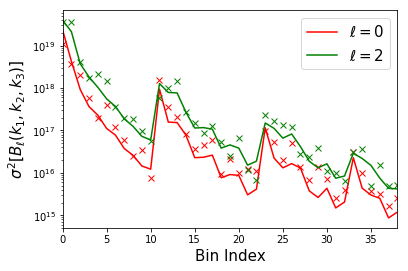

In [8]:
# Compute the empirical variances
bk_out = []
tot_sim = 10
for sim in range(tot_sim):
    print("# Analyzing simulation %d of %d"%(sim+1,tot_sim))
    cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=sim)

    # Add some redshift-space distortions along the z-axis
    cat['Position'] += cat['VelocityOffset'] * [0,0,1]
    cat['Position'] %= boxsize
    cat['Position'] -= boxsize/2. # center on zero

    # Convert the catalog to a grid, with CIC interpolation and interlacing
    density_grid = cat.to_mesh(compensated=False, resampler='tsc', interlaced=True, position='Position').compute()
    density_grid -= 1.
    
    # Compute the power spectra
    bk_out.append(bspec.Bk_ideal(density_grid, fish_ideal=fish_ideal_uncorr, discreteness_correction=False))

# Compute variances
bk_var = {}
bk_var['b0'] = np.var([b['b0'] for b in bk_out],axis=0)
bk_var['b2'] = np.var([b['b2'] for b in bk_out],axis=0)

# Compute theoretical covariance
theory_covariance = np.linalg.inv(fish_ideal_uncorr)

# Plot variances
for l in range(0,lmax+1,2):
    plt.plot(np.diag(theory_covariance)[l//2*bspec.N3:(l//2+1)*bspec.N3],c=cs[l//2],label=r'$\ell=%d$'%l)
    plt.plot(bk_var['b%d'%l],c=cs[l//2],marker='x',ls='')
plt.yscale('log')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\sigma^2\left[B_\ell(k_1,k_2,k_3)\right]$',fontsize=15)
plt.legend(fontsize=15);
plt.xlim(0,bspec.N3-1);

### 2. Unwindowed Power Spectra from Lightcones

Next, we'll compute the windowed and unwindowed bispectra from a simple lightcone dataset. Since this has non-trivial geometry (in particular, a local line-of-sight), we'll make use of the ```Bk_unwindowed``` routines, as well as implementing an (arbitrary) weighting scheme.

#### Setup dataset

We begin by creating some fake data displaced along a line-of-sight, as in Tutorial 1. We'll fix the normalization such that the data represents the overdensity (but not *fractional* overdensity) in each cell.

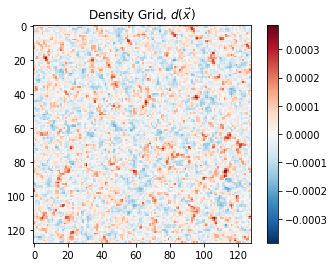

In [9]:
# Define line-of-sight
los_vector = np.asarray([0.,np.sqrt(2./3.),np.sqrt(1./3.)])
boxcenter = cosmo.comoving_distance(redshift)*los_vector

# Sample parameters
boxsize = [1000.,1000.,1000.]
gridsize = [128,128,128]

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)
assert gridsize[0]==gridsize[1]==gridsize[2], "Lognormals need cubic geometries!"
assert boxsize[0]==boxsize[1]==boxsize[2], "Lognormals need cubic geometries!"

# Add some redshift-space distortions along the line-of-sight [x -> x + (v.n)n]
cat['Position'] += np.sum(cat['VelocityOffset'] * los_vector, axis=1)[:,None]*los_vector
cat['Position'] %= boxsize
cat['Position'] -= np.asarray(boxsize)/2. # center on zero

# Create a uniform catalog of randoms
cat_rand = UniformCatalog(nbar*50,boxsize,42)
cat_rand['Position'] -= np.asarray(boxsize)/2. # center on zero

# Add weight attributes
shape = 0.*cat['Position'][:,0]
shape_rand = 0.*cat_rand['Position'][:,0]
cat['WEIGHT_FKP'] = 1.+shape
cat['WEIGHT'] = 1.+shape
cat['NZ'] = np.sum(cat['WEIGHT'])/np.asarray(boxsize).prod()+shape
cat_rand['WEIGHT_FKP'] = 1.+shape_rand
cat_rand['WEIGHT'] = 1.+shape_rand
cat_rand['NZ'] = np.sum(cat['WEIGHT'])/np.asarray(boxsize).prod()+shape_rand

cat['TOT_WEIGHT'] = cat['WEIGHT']*cat['WEIGHT_FKP']
cat_rand['TOT_WEIGHT'] = cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']

# Create data and random meshs
mesh_data = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()
mesh_rand = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()

# Normalize fields
mesh_data = mesh_data*np.sum(cat['TOT_WEIGHT']).compute()
mesh_rand = mesh_rand*np.sum(cat_rand['TOT_WEIGHT']).compute()

# Define ratio of maps
alpha = (np.sum(cat['WEIGHT'])/np.sum(cat_rand['WEIGHT'])).compute()

# Normalize density field to give *density* in each cell (like observational data)
density_grid = (mesh_data-alpha*mesh_rand)/np.asarray(boxsize).prod()

# Define a mask, i.e. the background density field
constant_mask = nbar

plotter(density_grid, title=r'Density Grid, $d(\vec x)$')

Now we set up PolyBin3D and a weighting scheme $\mathsf{S}^{-1}$. This proceeds exactly as before, and we'll use the simple form
$$\mathsf{S}^{-1}(\vec x,\vec y) = \int_{\vec k}e^{i\vec k\cdot(\vec x-\vec y)}\frac{1}{P(\vec k)},$$
noting that we have assumed a constant-everywhere mask.

In [10]:
# Define the redshift-space power spectrum on the grid 
Pk_grid =  interp1d(k_arr,P0_arr, bounds_error=False)(base.modk_grid)
Pk_grid += interp1d(k_arr,P2_arr, bounds_error=False)(base.modk_grid)*legendre(2)(base.muk_grid)
Pk_grid += interp1d(k_arr,P4_arr, bounds_error=False)(base.modk_grid)*legendre(4)(base.muk_grid)

# Invert safely
k_weighting = np.zeros_like(Pk_grid)
k_weighting[(Pk_grid!=0)&(~np.isnan(Pk_grid))] = 1./Pk_grid[(Pk_grid!=0)&(~np.isnan(Pk_grid))]

# Add mean density
k_weighting /= nbar

def applySinv_simple(input_data, input_type='real', output_type='real'):
    """Apply a filter to the data."""
   
    # Read in the data, and convert it to Fourier-space if necessary
    if input_type=='real':
        input_fourier = base.to_fourier(input_data)
    else:
        input_fourier = input_data.copy()
    
    # Apply Fourier-space weighting
    Sinv_fourier = input_fourier*k_weighting
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return base.to_real(Sinv_fourier)
    else:
        return Sinv_fourier

#### Compute $B_\ell(k_1,k_2,k_3)$ 

We can now compute the bispectra. This requires two pieces (a) the [Fisher] normalization matrix, $\mathcal{F}$, and (b) the bispectrum numerator, $\hat{c}$. These are combined according to $\mathcal{F}^{-1}\hat{c}$.

We'll first compute the Fisher matrix using Monte Carlo methods. This can be expensive to compute (particularly in the Yamamoto approximation), and should usually be paralellized. Notably, this does *not* depend on the data, thus can be pre-computed. If working at high gridsize or with many bins, this may also warrant computation on a high-memory node, since the algorithm stores $\mathcal{O}(N_{\rm bins})$ FFT grids in memory.

Here, we use 5 realizations for testing, computed via the ```compute_fisher_contribution``` routine. The whole computation can be wrapped via the ```compute_fisher``` method, which additionally allows for multi-processing.

In [11]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.10,0.02)
k_edges_squeeze = np.arange(0.01,0.15,0.02) # add extra high-k bins for squeezed triangles
lmax = 2

# Load the bispectrum class
bspec = pb.BSpec(base, 
                 k_edges, # one-dimensional bin edges
                 applySinv = applySinv_simple, # weighting function [only needed for unwindowed estimators]
                 mask = constant_mask, # real-space mask
                 lmax = lmax, # maximum Legendre multipole
                 k_bins_squeeze = k_edges_squeeze, # squeezed bins
                 include_partial_triangles = False, # whether to include bins whose centers do not satisfy triangle conditions
                )

# Number of Monte Carlo iterations
N_it = 5

# Iterate over realizations
fishs = []
for s in range(N_it):
    print("\n## Computing iteration %d of %d"%(s+1,N_it))
    fishs.append(bspec.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output
fish = np.mean(fishs,axis=0)
fish_sd = np.std(fishs,axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish = bspec.compute_fisher(N_it, N_cpus=1, verb=True)


Binning: 4 bins in [0.010, 0.090] h/Mpc
Squezed binning: 6 bins in [0.010, 0.130] h/Mpc
l-max: 2
N_bins: 78
Mask: constant

## Computing iteration 1 of 5
Computing degeneracy factor
Generating GRFs
Allocating 4.88 GB of memory

# Computing Q[S^-1.W.a] maps for random field 1
Computing g_{b,0}(r) maps
Computing matrix for k-bin 0 of 6
Computing matrix for k-bin 1 of 6
Computing matrix for k-bin 2 of 6
Computing matrix for k-bin 3 of 6
Computing matrix for k-bin 4 of 6
Computing matrix for k-bin 5 of 6

# Computing S^-1.W.Q[A^-1.a] maps for random field 1
Computing g_{b,0}(r) maps
Computing matrix for k-bin 0 of 6
Computing matrix for k-bin 1 of 6
Computing matrix for k-bin 2 of 6
Computing matrix for k-bin 3 of 6
Computing matrix for k-bin 4 of 6
Computing matrix for k-bin 5 of 6

# Computing Q[S^-1.W.a] maps for random field 2
Computing g_{b,0}(r) maps
Computing matrix for k-bin 0 of 6
Computing matrix for k-bin 1 of 6
Computing matrix for k-bin 2 of 6
Computing matrix for k-bin 3 of 

Let's compute the ideal Fisher matrix and compare it to that computed above. Similar to the power spectrum, the diagonal elements are quite similar, though there are differences at the $\mathcal{O}(10\%)$ and the off-diagonals differ. This is because we have included anisotropy in the $\mathsf{S}^{-1}$ weighting (with the ideal estimator just using a monopole weighting), and have taken the local line-of-sight into account. The residual noise in the Fisher matrix (which is largest for squeezed triangles with $\ell>0$) can be reduced by using more Monte Carlo realizations to define the Fisher matrix; it scales as $1/N_{\rm it}$. 

Computing ideal Fisher matrix


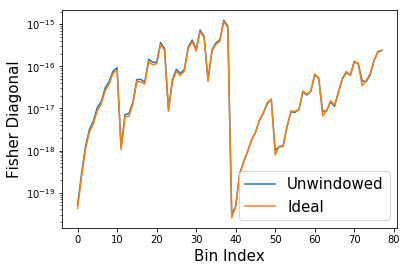

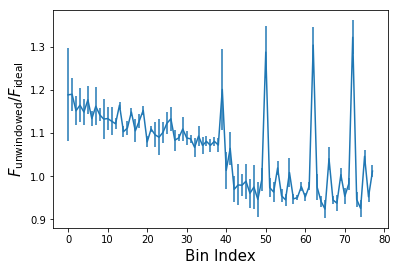

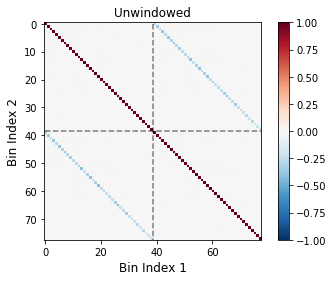

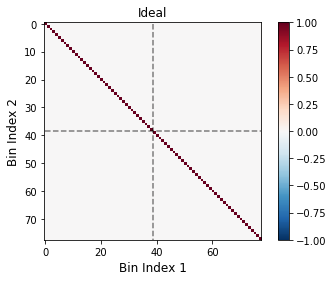

In [12]:
# Compute ideal fisher
fish_ideal = bspec.compute_fisher_ideal(discreteness_correction=False)

# Plot diagonals
plt.plot(np.diag(fish),label='Unwindowed')
plt.plot(np.diag(fish_ideal),label='Ideal')
plt.yscale('log')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'Fisher Diagonal',fontsize=15)
plt.legend(fontsize=15);

# Plot ratios
plt.figure()
plt.errorbar(np.arange(bspec.N_bins),np.diag(fish)/np.diag(fish_ideal),yerr=np.diag(fish_sd)/np.diag(fish_ideal))
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$F_{\rm unwindowed}/F_{\rm ideal}$',fontsize=15)

# Plot correlation matrices
plot_corr(fish, 1, subtract_identity=False, title='Unwindowed')
plot_corr(fish_ideal, 1, subtract_identity=False, title='Ideal')

We now compute the full unwindowed and ideal bispectra, specifying the Fisher matrix we just computed. When using the unwindowed estimator, we have an important choice to make: should we subtract off the linear term in the bispectrum estimator? This amounts to using an estimator of the form $\Pi^{ijk}\left(d_id_jd_k-d_i\langle{d_jd_k\rangle}+\text{perms.}\right)$ instead of just $\Pi^{ijk}d_id_jd_k$ (for some weighting $\Pi$). This does not change the estimator bias, but will slightly reduce the large-scale variance (though is trivial in the ideal limit).

If we do *not* subtract off the linear term, the bispectrum numerator can be computed as for the ideal case, as we show below. Here, we find excellent agreement between the ideal and unwindowed bispectrum monopoles, as expected (since only the weighting changes). For the quadrupole, we find slight differences on large-scales, which could indicate (a) the impact of the Yamamoto line-of-sight (which creates slight biases in the ideal estimator); (b) Monte Carlo noise in the Fisher matrices; (c) differences due to the slightly-more-optimal anisotropic weighting scheme assumed (which can affect the variance, though not the mean). 

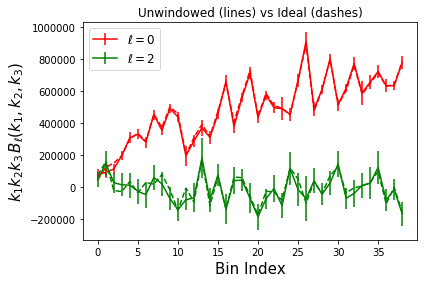

In [13]:
# Compute unwindowed bispectrum, without removing the linear term
bk = bspec.Bk_unwindowed(density_grid, fish=fish, include_linear_term=False)

# Compute ideal bispectrum
bk_ideal = bspec.Bk_ideal(density_grid, discreteness_correction=False) # this normalizes the field by < mask^3 > 

cs = ['r','g']
weight = k123.prod(axis=0)
for l in range(0,lmax+1,2):
    plt.errorbar(np.arange(len(weight)), 
                 weight*bk['b%d'%l],c=cs[l//2],
                 yerr=weight*np.sqrt(np.diag(bspec.inv_fish))[l//2*bspec.N3:(l//2+1)*bspec.N3],
                 label=r'$\ell=%d$'%l)
    plt.plot(weight*bk_ideal['b%d'%l],c=cs[l//2],ls='--')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12);
plt.title('Unwindowed (lines) vs Ideal (dashes)',fontsize=12);

Now, let's compute the bispectra including the linear term. To do this, we need to either input or generate a set of Monte Carlo simulations, which allow the expectation $\langle{d_jd_k\rangle}$ to be computed numerically. To set this up we have two options:
1. ```generate_sims()```: Create GRF simulations internally, including the survey mask (appleid before the pixellation window), generated with the specified power spectrum. Redshift-space distortions are added along the mean line-of-sight to the survey.
2. ```load_sims()```: Read-in externally computed simulations, such as mock catalogs. These should include the window function and geometry effects, but are not required to have higher-point functions (bispectra and beyond) matching the data.

Both approaches are demonstrated below using a small number of simulations for testing. The ``preload`` parameter sets how PolyBin3D handles the simulations: if True, the simulations are analyzed and loaded into memory immediately, whilst if False, they are loaded only when needed. The latter approach is more memory-efficient, though can be lossy if many datasets are analyzed at once.

In [14]:
N_linear = 10 # number of linear-term simulations
preload = True # whether to pre-compute simulations

### Load internally created GRF simulations with the specified power spectrum
bspec.generate_sims(N_linear, Pk_input=Pk_theory, preload=preload, verb=True)

## Alternatively: read-in external simulations. Here demonstrated with a GRF.
# def load_sim(ii):
#     """Generate a single GRF simulation."""

#     if bspec.const_mask:
#         # Generate simulation in real-space
#         return bspec.mask_mean*base.generate_data(int(1e5)+ii, output_type='real')

#     else:
#         # Generate base simulation in real-space, without pixel window
#         sim_real = bspec.mask*base.generate_data(int(1e5)+ii, output_type='real', include_pixel_window=False)

#         # Apply pixel window
#         if base.pixel_window!='none':
#             sim_real = base.to_fourier(sim_real)*base.pixel_window_grid
#         return sim_real
  
# # Load simulations
# bspec.load_sims(load_sim, N_linear, input_type='real', preload=preload, verb=True)

Using 10 Monte Carlo simulations
Generating bias simulation 1 of 10
Generating bias simulation 2 of 10
Generating bias simulation 3 of 10
Generating bias simulation 4 of 10
Generating bias simulation 5 of 10
Generating bias simulation 6 of 10
Generating bias simulation 7 of 10
Generating bias simulation 8 of 10
Generating bias simulation 9 of 10
Generating bias simulation 10 of 10


Now we can compute the bispectra. This will take $\mathcal{O}(N_{\rm sim})$ times longer than before, due to the extra Monte Carlo simulations we have to analyze. Notably, we find only small differences between the estimators, much of which can be explained by Monte Carlo noise. This is partly due to the simplified geometry that has been assumed above; in reality, this term will slightly reduce the large-scale variance. 


Computing g_{b,0}(r) maps
Computing g_{b,2}(r) maps
Computing cubic term
No linear correction applied!

Computing g_{b,0}(r) maps
Computing g_{b,2}(r) maps
Computing cubic term
Computing linear term
On simulation 5 of 10
On simulation 10 of 10


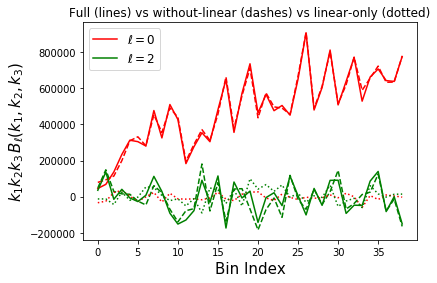

In [15]:
# Compute unwindowed bispectrum, without removing the linear term
bk_nolinear = bspec.Bk_unwindowed(density_grid, fish=fish, include_linear_term=False, verb=True)
bk_wlinear = bspec.Bk_unwindowed(density_grid, fish=fish, include_linear_term=True, verb=True)

cs = ['r','g']
weight = k123.prod(axis=0)
for l in range(0,lmax+1,2):
    plt.errorbar(np.arange(len(weight)), 
                 weight*(bk_wlinear['b%d'%l]-bk_nolinear['b%d'%l]),c=cs[l//2],ls=':')
    plt.errorbar(np.arange(len(weight)), 
                 weight*bk_wlinear['b%d'%l],c=cs[l//2],label=r'$\ell=%d$'%l)
    plt.plot(weight*bk_nolinear['b%d'%l],c=cs[l//2],ls='--')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12);
plt.title('Full (lines) vs without-linear (dashes) vs linear-only (dotted)',fontsize=12);

#### Compute Variances

Finally, let's test the optimality of our estimator. As for the power spectrum, this can be done by creating a set of anisotropic GRF testing simulations and estimating their covariance matrix. If the $\mathsf{S}^{-1}$ weighting is optimal, the inverse Fisher matrix should match the covariance of the data. For this test, we'll drop the linear term in the bispectrum esitmator, since it is expensive and we have already shown it to be small for our set-up.

In [16]:
# Compute the empirical variances
bk_out_unwindowed = []

tot_sim = 25
for sim in range(tot_sim):
    if (sim+1)%5==0: print("# Analyzing simulation %d of %d"%(sim+1,tot_sim))
    
    # Generate an anisotropic Gaussian random field density map
    sim_grid = base.generate_data(sim, Pk_theory)*nbar
    
    # Compute the power spectra
    bk_out_unwindowed.append(bspec.Bk_unwindowed(sim_grid, include_linear_term=False))    

# Compute variances
bk_var = {}
bk_var['b0'] = np.var([b['b0'] for b in bk_out_unwindowed],axis=0)
bk_var['b2'] = np.var([b['b2'] for b in bk_out_unwindowed],axis=0)

# Compute theoretical covariance
theory_covariance = bspec.inv_fish

# Analyzing simulation 5 of 25
# Analyzing simulation 10 of 25
# Analyzing simulation 15 of 25
# Analyzing simulation 20 of 25
# Analyzing simulation 25 of 25


Below, we find that the variances and correlation structures are in good agreement. This is an important test of our methodology, and serves to validate the unwindowed estimators, at least in the simplified limits considered above. We note that some small differences can arise from the fact that the GRF simulations are generated with global lines-of-sight but analyzed in the Yamamoto formalism, as well as from residual Monte Carlo noise.

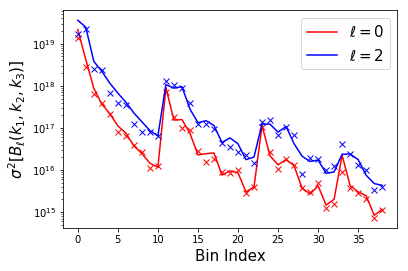

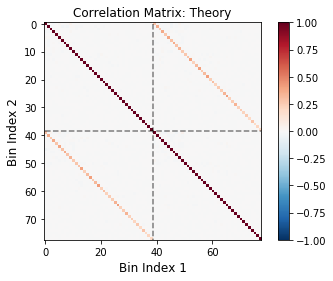

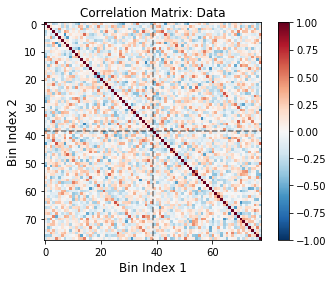

In [17]:
# Plot variances
cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(np.diag(theory_covariance)[l//2*bspec.N3:(l//2+1)*bspec.N3],c=cols[l//2],label=r'$\ell=%d$'%l)
    plt.plot(bk_var['b%d'%l],c=cols[l//2],marker='x',ls='')
plt.yscale('log')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\sigma^2\left[B_\ell(k_1,k_2,k_3)\right]$',fontsize=15)
plt.legend(fontsize=15);

# Plot correlation matrix
theory_corr = theory_covariance/np.sqrt(np.outer(np.diag(theory_covariance),np.diag(theory_covariance)))
plot_corr(theory_corr, 1, subtract_identity=False, title='Correlation Matrix: Theory')

# Compute covariance
data_covariance = np.cov(np.asarray([np.hstack([b['b0'],b['b2']]) for b in bk_out_unwindowed]).T)

# Plot empirical matrix
data_corr = data_covariance/np.sqrt(np.outer(np.diag(data_covariance),np.diag(data_covariance)))
plot_corr(data_corr, 1, subtract_identity=False, title='Correlation Matrix: Data')

This completes the tutorial! In the next bispectrum tutorial, we'll validate the unwindowed estimators by applying them to masked simulation data.